The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Predicting House Prices on Kaggle
:label:`sec_kaggle_house`

Now that we have introduced some basic tools
for building and training deep networks
and regularizing them with techniques including
weight decay and dropout,
we are ready to put all this knowledge into practice
by participating in a Kaggle competition.
The house price prediction competition
is a great place to start.
The data is fairly generic and do not exhibit exotic structure
that might require specialized models (as audio or video might).
This dataset, collected by :citet:`De-Cock.2011`,
covers house prices in Ames, Iowa from the period 2006--2010.
It is considerably larger than the famous [Boston housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names) of Harrison and Rubinfeld (1978),
boasting both more examples and more features.


In this section, we will walk you through details of
data preprocessing, model design, and hyperparameter selection.
We hope that through a hands-on approach,
you will gain some intuitions that will guide you
in your career as a data scientist.


In [2]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## Downloading Data

Throughout the book, we will train and test models
on various downloaded datasets.
Here, we (**implement two utility functions**)
for downloading and extracting zip or tar files.
Again, we skip implementation details of
such utility functions.


In [3]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

## Kaggle

[Kaggle](https://www.kaggle.com) is a popular platform
that hosts machine learning competitions.
Each competition centers on a dataset and many
are sponsored by stakeholders who offer prizes
to the winning solutions.
The platform helps users to interact
via forums and shared code,
fostering both collaboration and competition.
While leaderboard chasing often spirals out of control,
with researchers focusing myopically on preprocessing steps
rather than asking fundamental questions,
there is also tremendous value in the objectivity of a platform
that facilitates direct quantitative comparisons
among competing approaches as well as code sharing
so that everyone can learn what did and did not work.
If you want to participate in a Kaggle competition,
you will first need to register for an account
(see :numref:`fig_kaggle`).

![The Kaggle website.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle.png?raw=1)
:width:`400px`
:label:`fig_kaggle`

On the house price prediction competition page, as illustrated
in :numref:`fig_house_pricing`,
you can find the dataset (under the "Data" tab),
submit predictions, and see your ranking,
The URL is right here:

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![The house price prediction competition page.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/house-pricing.png?raw=1)
:width:`400px`
:label:`fig_house_pricing`

## Accessing and Reading the Dataset

Note that the competition data is separated
into training and test sets.
Each record includes the property value of the house
and attributes such as street type, year of construction,
roof type, basement condition, etc.
The features consist of various data types.
For example, the year of construction
is represented by an integer,
the roof type by discrete categorical assignments,
and other features by floating point numbers.
And here is where reality complicates things:
for some examples, some data is altogether missing
with the missing value marked simply as "na".
The price of each house is included
for the training set only
(it is a competition after all).
We will want to partition the training set
to create a validation set,
but we only get to evaluate our models on the official test set
after uploading predictions to Kaggle.
The "Data" tab on the competition tab
in :numref:`fig_house_pricing`
has links for downloading the data.

To get started, we will [**read in and process the data
using `pandas`**], which we introduced in :numref:`sec_pandas`.
For convenience, we can download and cache
the Kaggle housing dataset.
If a file corresponding to this dataset already exists in the cache directory and its SHA-1 matches `sha1_hash`, our code will use the cached file to avoid clogging up your Internet with redundant downloads.


In [4]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

The training dataset includes 1460 examples,
80 features, and one label, while the validation data
contains 1459 examples and 80 features.


In [5]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


## Data Preprocessing

Let's [**take a look at the first four and final two features
as well as the label (SalePrice)**] from the first four examples.


In [6]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


We can see that in each example, the first feature is the identifier.
This helps the model determine each training example.
While this is convenient, it does not carry
any information for prediction purposes.
Hence, we will remove it from the dataset
before feeding the data into the model.
Furthermore, given a wide variety of data types,
we will need to preprocess the data before we can start modeling.


Let's start with the numerical features.
First, we apply a heuristic,
[**replacing all missing values
by the corresponding feature's mean.**]
Then, to put all features on a common scale,
we (***standardize* the data by
rescaling features to zero mean and unit variance**):

$$x \leftarrow \frac{x - \mu}{\sigma},$$

where $\mu$ and $\sigma$ denote mean and standard deviation, respectively.
To verify that this indeed transforms
our feature (variable) such that it has zero mean and unit variance,
note that $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$
and that $E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$.
Intuitively, we standardize the data
for two reasons.
First, it proves convenient for optimization.
Second, because we do not know *a priori*
which features will be relevant,
we do not want to penalize coefficients
assigned to one feature more than any other.

[**Next we deal with discrete values.**]
These include features such as "MSZoning".
(**We replace them by a one-hot encoding**)
in the same way that we earlier transformed
multiclass labels into vectors (see :numref:`subsec_classification-problem`).
For instance, "MSZoning" assumes the values "RL" and "RM".
Dropping the "MSZoning" feature,
two new indicator features
"MSZoning_RL" and "MSZoning_RM" are created with values being either 0 or 1.
According to one-hot encoding,
if the original value of "MSZoning" is "RL",
then "MSZoning_RL" is 1 and "MSZoning_RM" is 0.
The `pandas` package does this automatically for us.


In [7]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

You can see that this conversion increases
the number of features from 79 to 331 (excluding ID and label columns).


In [8]:
data.preprocess()
data.train.shape

(1460, 331)

## Error Measure

To get started we will train a linear model with squared loss. Not surprisingly, our linear model will not lead to a competition-winning submission but it does provide a sanity check to see whether there is meaningful information in the data. If we cannot do better than random guessing here, then there might be a good chance that we have a data processing bug. And if things work, the linear model will serve as a baseline giving us some intuition about how close the simple model gets to the best reported models, giving us a sense of how much gain we should expect from fancier models.

With house prices, as with stock prices,
we care about relative quantities
more than absolute quantities.
Thus [**we tend to care more about
the relative error $\frac{y - \hat{y}}{y}$**]
than about the absolute error $y - \hat{y}$.
For instance, if our prediction is off by \$100,000
when estimating the price of a house in rural Ohio,
where the value of a typical house is \$125,000,
then we are probably doing a horrible job.
On the other hand, if we err by this amount
in Los Altos Hills, California,
this might represent a stunningly accurate prediction
(there, the median house price exceeds \$4 million).

(**One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.**)
In fact, this is also the official error measure
used by the competition to evaluate the quality of submissions.
After all, a small value $\delta$ for $|\log y - \log \hat{y}| \leq \delta$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [9]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

## $K$-Fold Cross-Validation

You might recall that we introduced [**cross-validation**]
in :numref:`subsec_generalization-model-selection`, where we discussed how to deal
with model selection.
We will put this to good use to select the model design
and to adjust the hyperparameters.
We first need a function that returns
the $i^\textrm{th}$ fold of the data
in a $K$-fold cross-validation procedure.
It proceeds by slicing out the $i^\textrm{th}$ segment
as validation data and returning the rest as training data.
Note that this is not the most efficient way of handling data
and we would definitely do something much smarter
if our dataset was considerably larger.
But this added complexity might obfuscate our code unnecessarily
so we can safely omit it here owing to the simplicity of our problem.


In [10]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

[**The average validation error is returned**]
when we train $K$ times in the $K$-fold cross-validation.


In [11]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

## [**Model Selection**]

In this example, we pick an untuned set of hyperparameters
and leave it up to the reader to improve the model.
Finding a good choice can take time,
depending on how many variables one optimizes over.
With a large enough dataset,
and the normal sorts of hyperparameters,
$K$-fold cross-validation tends to be
reasonably resilient against multiple testing.
However, if we try an unreasonably large number of options
we might find that our validation
performance is no longer representative of the true error.


average validation log mse = 0.17471326828002928


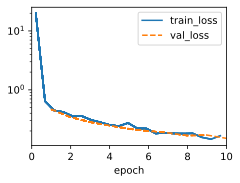

In [12]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

Notice that sometimes the number of training errors
for a set of hyperparameters can be very low,
even as the number of errors on $K$-fold cross-validation
grows considerably higher.
This indicates that we are overfitting.
Throughout training you will want to monitor both numbers.
Less overfitting might indicate that our data can support a more powerful model.
Massive overfitting might suggest that we can gain
by incorporating regularization techniques.

##  [**Submitting Predictions on Kaggle**]

Now that we know what a good choice of hyperparameters should be,
we might
calculate the average predictions
on the test set
by all the $K$ models.
Saving the predictions in a csv file
will simplify uploading the results to Kaggle.
The following code will generate a file called `submission.csv`.


In [13]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

Next, as demonstrated in :numref:`fig_kaggle_submit2`,
we can submit our predictions on Kaggle
and see how they compare with the actual house prices (labels)
on the test set.
The steps are quite simple:

* Log in to the Kaggle website and visit the house price prediction competition page.
* Click the “Submit Predictions” or “Late Submission” button.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

![Submitting data to Kaggle](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle-submit2.png?raw=1)
:width:`400px`
:label:`fig_kaggle_submit2`

## Summary and Discussion

Real data often contains a mix of different data types and needs to be preprocessed.
Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean.
Furthermore, transforming categorical features into indicator features allows us to treat them like one-hot vectors.
When we tend to care more about
the relative error than about the absolute error,
we can
measure the discrepancy in the logarithm of the prediction.
To select the model and adjust the hyperparameters,
we can use $K$-fold cross-validation .



## Exercises

1. Submit your predictions for this section to Kaggle. How good are they?
1. Is it always a good idea to replace missing values by a mean? Hint: can you construct a situation where the values are not missing at random?
1. Improve the score by tuning the hyperparameters through $K$-fold cross-validation.
1. Improve the score by improving the model (e.g., layers, weight decay, and dropout).
1. What happens if we do not standardize the continuous numerical features as we have done in this section?


1.按教材中的代码提交后，Kaggle评估显示log rmse=0.40613，排名4392。

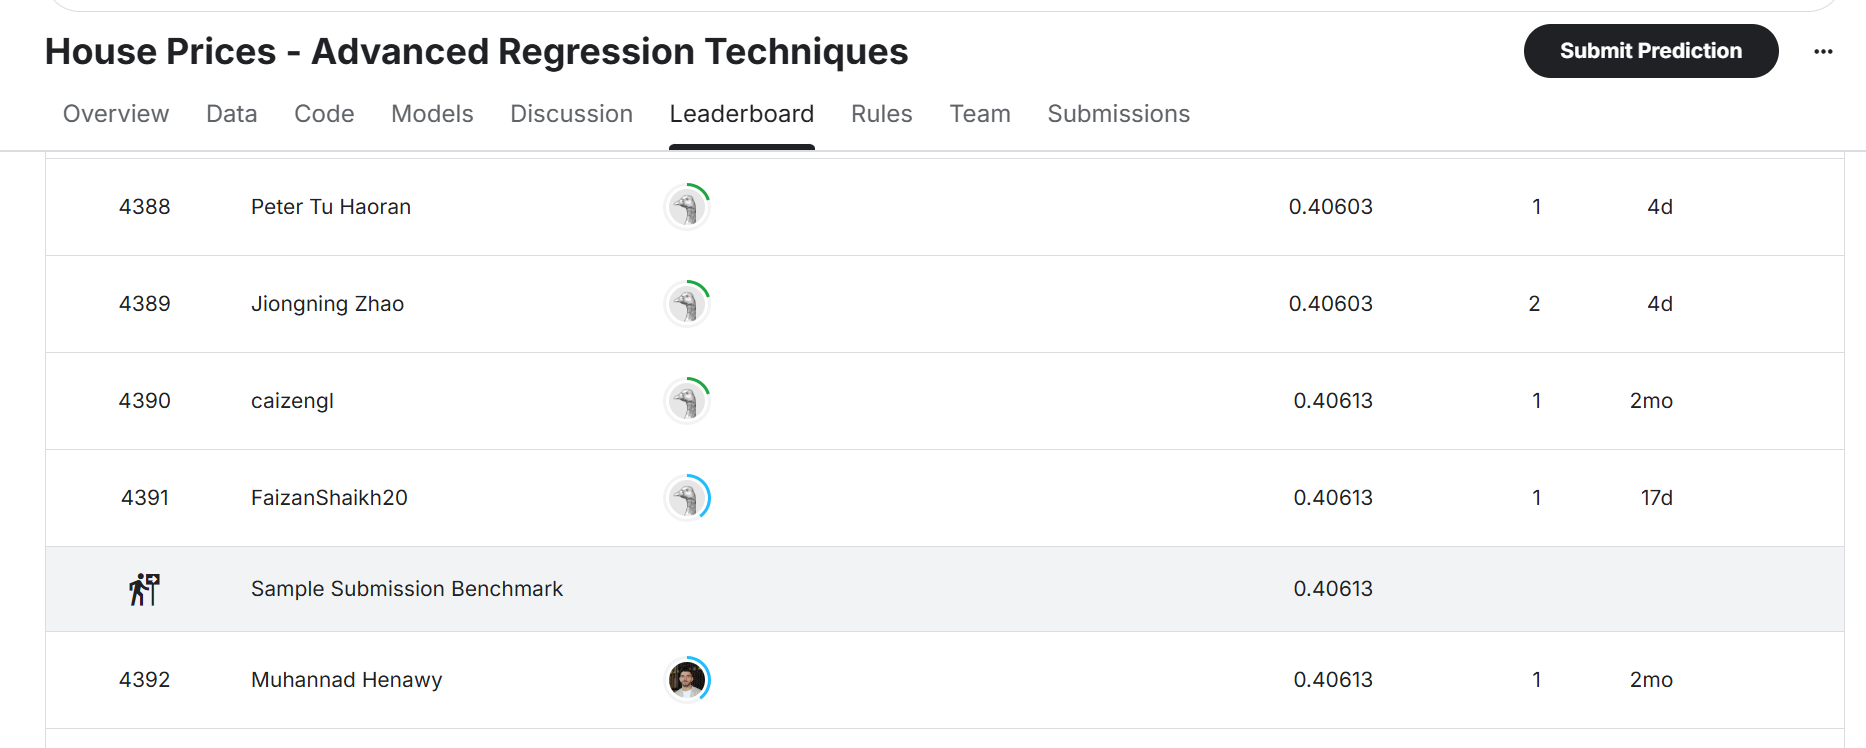

2、直接最小化价格的对数，也即将预测价格改为预测价格的对数，等价于将目标函数改为对数MSE。由以下结果可见，模型并未改进，代码如下：



折1，训练log rmse2.486354, 验证log rmse2.487481
折2，训练log rmse2.486527, 验证log rmse2.486790
折3，训练log rmse2.486307, 验证log rmse2.487668
折4，训练log rmse2.487313, 验证log rmse2.483643
折5，训练log rmse2.486396, 验证log rmse2.487313
5-折验证: 平均训练log rmse: 2.486579, 平均验证log rmse: 2.486579


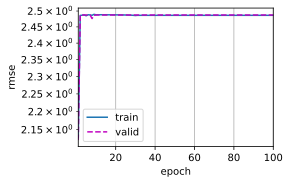

3、用平均值替换缺失值并不总是一个好主意，因为这可能会导致数据失真或者模型表现下降。替代缺失值的方法应该根据数据的特点和缺失值产生的原因来选择。

比如，一个数据集中的某个属性代表的是某种物质的浓度，这种物质在某个特定温度下会分解，因此在这个温度下所有样本的该属性值都是缺失的。在这种情况下，如果直接用平均值替换缺失值，则可能会导致数据严重失真。

In [22]:
from sklearn.model_selection import KFold
import numpy as np

def k_fold_cv(model_func, X, y, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = model_func()
        model.fit(X_train, y_train)
        score = evaluate(model, X_val, y_val)
        scores.append(score)

    return np.mean(scores)

=== Kaggle 房价预测竞赛解决方案 ===

训练集形状: (1460, 81)
测试集形状: (1459, 80)
原始数据加载完成!
=== 数据基本信息 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseSty

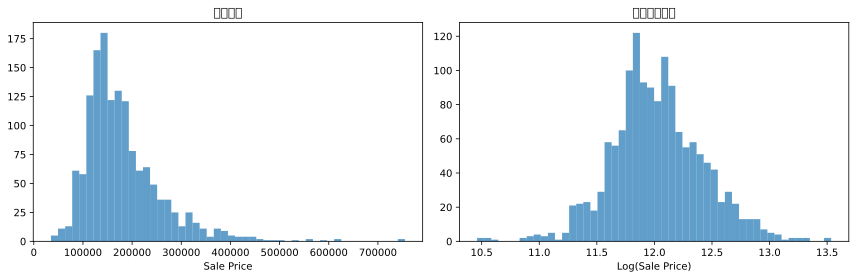


开始数据预处理...
处理后训练集形状: (1460, 225)
处理后测试集形状: (1459, 225)
开始训练模型...
训练 ridge...
ridge CV Score: 0.15660 (+/- 0.06568)
训练 lasso...
lasso CV Score: 0.15993 (+/- 0.07013)
训练 elastic...
elastic CV Score: 0.16626 (+/- 0.07005)
训练 rf...
rf CV Score: 0.14281 (+/- 0.03625)
训练 gbm...
gbm CV Score: 0.13279 (+/- 0.03291)
训练 xgb...
xgb CV Score: 0.14494 (+/- 0.02863)
训练 lgb...
lgb CV Score: 0.13302 (+/- 0.03347)

生成最终预测...

提交文件已生成: submission.csv
预测价格范围: $52528 - $542035
预测价格均值: $177286

=== 模型性能总结 ===
ridge   : 0.15660 (+/- 0.06568)
lasso   : 0.15993 (+/- 0.07013)
elastic : 0.16626 (+/- 0.07005)
rf      : 0.14281 (+/- 0.03625)
gbm     : 0.13279 (+/- 0.03291)
xgb     : 0.14494 (+/- 0.02863)
lgb     : 0.13302 (+/- 0.03347)


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# ================================
# 1. 数据加载和基本探索
# ================================

def load_data():
    """
    加载Kaggle房价数据
    你需要从 https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
    下载 train.csv 和 test.csv
    """
    try:
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        print(f"训练集形状: {train_df.shape}")
        print(f"测试集形状: {test_df.shape}")
        return train_df, test_df
    except FileNotFoundError:
        print("请先下载数据集:")
        print("1. 访问 https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data")
        print("2. 下载 train.csv 和 test.csv 到当前目录")
        return None, None

def explore_data(df):
    """数据探索"""
    print("=== 数据基本信息 ===")
    print(df.info())
    print("\n=== 缺失值统计 ===")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    print(missing)

    if 'SalePrice' in df.columns:
        print(f"\n=== 目标变量统计 ===")
        print(df['SalePrice'].describe())

        # 价格分布图
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.hist(df['SalePrice'], bins=50, alpha=0.7)
        plt.title('房价分布')
        plt.xlabel('Sale Price')

        plt.subplot(1, 2, 2)
        plt.hist(np.log1p(df['SalePrice']), bins=50, alpha=0.7)
        plt.title('房价对数分布')
        plt.xlabel('Log(Sale Price)')
        plt.tight_layout()
        plt.show()

# ================================
# 2. 数据预处理
# ================================

def handle_missing_values(df):
    """处理缺失值"""
    df = df.copy()

    # 对于这些特征，缺失值表示"无"
    none_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                    'BsmtFinType2', 'MasVnrType']

    for feature in none_features:
        if feature in df.columns:
            df[feature] = df[feature].fillna('None')

    # 数值型特征用0填充
    zero_features = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
                    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
                    'BsmtHalfBath', 'MasVnrArea']

    for feature in zero_features:
        if feature in df.columns:
            df[feature] = df[feature].fillna(0)

    # 其他特征的处理
    if 'LotFrontage' in df.columns:
        df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
            lambda x: x.fillna(x.median()))

    # 类别型特征用众数填充
    categorical_features = df.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        if df[feature].isnull().sum() > 0:
            df[feature] = df[feature].fillna(df[feature].mode()[0])

    # 数值型特征用中位数填充
    numerical_features = df.select_dtypes(include=[np.number]).columns
    for feature in numerical_features:
        if df[feature].isnull().sum() > 0:
            df[feature] = df[feature].fillna(df[feature].median())

    return df

def feature_engineering(df):
    """特征工程"""
    df = df.copy()

    # 创建新特征
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                           df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                         df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])

    # 房龄特征
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    df['GarageAge'] = df['GarageAge'].fillna(0)  # 没有车库的设为0

    # 是否翻新
    df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)

    # 是否有地下室、车库等
    df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)

    return df

def encode_categorical_features(train_df, test_df):
    """编码类别型特征"""
    # 合并训练和测试集以确保编码一致
    train_len = len(train_df)
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    # 获取类别型特征
    categorical_features = combined_df.select_dtypes(include=['object']).columns
    categorical_features = [col for col in categorical_features if col != 'Id']

    # 对序数特征进行手动编码
    ordinal_mappings = {
        'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None': 0},
        'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None': 0},
        'BsmtQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None': 0},
        'BsmtCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None': 0},
        'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None': 0},
        'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None': 0},
        'FireplaceQu': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None': 0},
        'GarageQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None': 0},
        'GarageCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None': 0},
        'PoolQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None': 0},
        'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
        'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
        'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
        'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
    }

    # 应用序数编码
    for feature, mapping in ordinal_mappings.items():
        if feature in combined_df.columns:
            combined_df[feature] = combined_df[feature].map(mapping)

    # 对剩余的类别型特征进行独热编码
    remaining_categorical = []
    for col in categorical_features:
        if col not in ordinal_mappings:
            remaining_categorical.append(col)

    # 独热编码
    combined_df = pd.get_dummies(combined_df, columns=remaining_categorical, drop_first=True)

    # 分离训练和测试集
    train_processed = combined_df[:train_len]
    test_processed = combined_df[train_len:]

    return train_processed, test_processed

# ================================
# 3. 模型构建和训练
# ================================

class HousePricePredictor:
    def __init__(self):
        self.models = {
            'ridge': Ridge(alpha=10),
            'lasso': Lasso(alpha=0.001),
            'elastic': ElasticNet(alpha=0.001, l1_ratio=0.5),
            'rf': RandomForestRegressor(n_estimators=100, random_state=42),
            'gbm': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'xgb': xgb.XGBRegressor(n_estimators=100, random_state=42),
            'lgb': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
        }
        self.scaler = StandardScaler()
        self.best_models = {}

    def rmsle_cv(self, model, X, y, cv=5):
        """K折交叉验证计算RMSLE"""
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
        return rmse

    def train_models(self, X, y):
        """训练所有模型"""
        print("开始训练模型...")

        # 标准化特征
        X_scaled = self.scaler.fit_transform(X)

        # 对数变换目标变量
        y_log = np.log1p(y)

        model_scores = {}

        for name, model in self.models.items():
            print(f"训练 {name}...")

            # 交叉验证
            cv_scores = self.rmsle_cv(model, X_scaled, y_log)
            model_scores[name] = {
                'mean_cv_score': cv_scores.mean(),
                'std_cv_score': cv_scores.std()
            }

            # 训练模型
            model.fit(X_scaled, y_log)
            self.best_models[name] = model

            print(f"{name} CV Score: {cv_scores.mean():.5f} (+/- {cv_scores.std() * 2:.5f})")

        return model_scores

    def ensemble_predict(self, X):
        """集成预测"""
        X_scaled = self.scaler.transform(X)
        predictions = []

        # 权重（可以根据CV分数调整）
        weights = {
            'ridge': 0.1,
            'lasso': 0.1,
            'elastic': 0.1,
            'rf': 0.2,
            'gbm': 0.2,
            'xgb': 0.15,
            'lgb': 0.15
        }

        ensemble_pred = np.zeros(X.shape[0])

        for name, model in self.best_models.items():
            pred = model.predict(X_scaled)
            ensemble_pred += weights[name] * pred

        # 转换回原始尺度
        return np.expm1(ensemble_pred)

# ================================
# 4. 主函数
# ================================

def main():
    """主函数"""
    print("=== Kaggle 房价预测竞赛解决方案 ===\n")

    # 1. 加载数据
    train_df, test_df = load_data()
    if train_df is None:
        return

    print("原始数据加载完成!")

    # 2. 数据探索
    explore_data(train_df)

    # 3. 数据预处理
    print("\n开始数据预处理...")

    # 保存目标变量和ID
    train_target = train_df['SalePrice']
    test_ids = test_df['Id']

    # 删除目标变量和ID
    train_features = train_df.drop(['SalePrice'], axis=1)

    # 处理缺失值
    train_features = handle_missing_values(train_features)
    test_df = handle_missing_values(test_df)

    # 特征工程
    train_features = feature_engineering(train_features)
    test_df = feature_engineering(test_df)

    # 编码类别型特征
    train_processed, test_processed = encode_categorical_features(train_features, test_df)

    # 删除ID列
    if 'Id' in train_processed.columns:
        train_processed = train_processed.drop('Id', axis=1)
    if 'Id' in test_processed.columns:
        test_processed = test_processed.drop('Id', axis=1)

    print(f"处理后训练集形状: {train_processed.shape}")
    print(f"处理后测试集形状: {test_processed.shape}")

    # 4. 模型训练
    predictor = HousePricePredictor()
    model_scores = predictor.train_models(train_processed, train_target)

    # 5. 生成预测
    print("\n生成最终预测...")
    test_predictions = predictor.ensemble_predict(test_processed)

    # 6. 创建提交文件
    submission = pd.DataFrame({
        'Id': test_ids,
        'SalePrice': test_predictions
    })

    submission.to_csv('submission.csv', index=False)
    print("\n提交文件已生成: submission.csv")
    print(f"预测价格范围: ${test_predictions.min():.0f} - ${test_predictions.max():.0f}")
    print(f"预测价格均值: ${test_predictions.mean():.0f}")

    # 7. 显示模型性能
    print("\n=== 模型性能总结 ===")
    for name, scores in model_scores.items():
        print(f"{name:8s}: {scores['mean_cv_score']:.5f} (+/- {scores['std_cv_score']*2:.5f})")

if __name__ == "__main__":
    main()

# ================================
# 5. 额外的分析函数
# ================================

def analyze_feature_importance(predictor, feature_names):
    """分析特征重要性"""
    # Random Forest特征重要性
    rf_importance = predictor.best_models['rf'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance_df.head(20), x='importance', y='feature')
    plt.title('Top 20 特征重要性 (Random Forest)')
    plt.xlabel('重要性')
    plt.tight_layout()
    plt.show()

    return feature_importance_df

def plot_predictions_vs_actual(predictor, X_test, y_test):
    """绘制预测值 vs 实际值"""
    predictions = predictor.ensemble_predict(X_test)

    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('实际价格')
    plt.ylabel('预测价格')
    plt.title('预测价格 vs 实际价格')

    # 计算R²
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test, predictions)
    plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

[Discussions](https://discuss.d2l.ai/t/107)
